In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras import layers, regularizers

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [2]:
from sklearn.model_selection import train_test_split, KFold, cross_validate, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import roc_curve, auc

In [3]:
data = pd.read_csv('hotel_bookings.csv')
data_cln = data.fillna({'children': 0.0, 'country': 'Unknown', 'agent':0, 'company': 0})
data_cln['meal'].replace('Undefined', 'SC', inplace = True)

num_features = ["lead_time","arrival_date_week_number","arrival_date_day_of_month",
                "stays_in_weekend_nights","stays_in_week_nights","adults","children",
                "babies","is_repeated_guest", "previous_cancellations",
                "previous_bookings_not_canceled","agent","company",
                "required_car_parking_spaces", "total_of_special_requests", "adr"]

cat_features = ["arrival_date_month","meal","market_segment",
                "distribution_channel","reserved_room_type","deposit_type","customer_type"]

# Separate features and predicted value
features = num_features + cat_features

# preprocess numerical feats:
# for most num cols, except the dates, 0 is the most logical choice as fill value
# and here no dates are missing.
num_transformer = SimpleImputer(strategy="constant")

# Preprocessing for categorical features:
cat_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value="Unknown")),
    ("onehot", OneHotEncoder(handle_unknown='ignore'))])

# Bundle preprocessing for numerical and categorical features:
preprocessor = ColumnTransformer(transformers=[("num", num_transformer, num_features),
                                               ("cat", cat_transformer, cat_features)])



In [4]:
resort_data = data_cln[data_cln.hotel == 'Resort Hotel']
city_data = data_cln[data_cln.hotel == 'City Hotel']

In [5]:
def test_model_1():
    inputs = keras.Input(shape=(59,), dtype = "float32")
    
    x = layers.Dense(256)(inputs)
#     x = layers.Dense(256)(x)
#     x = layers.Dense(256)(x)
    x = layers.Dense(128)(x)
    x = layers.Dense(64)(x)
    x = layers.Dense(32)(x)
    x = layers.Dense(16)(x)
    outputs = layers.Dense(1, activation='sigmoid',
                    kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))(x)
    model = keras.Model(inputs, outputs)
    # model.summary()

    model.compile("adam", "binary_crossentropy", metrics=["accuracy", "AUC"])
    return model

In [6]:
# kfolds = 10 
# kf = KFold(n_splits=kfolds, shuffle=True, random_state=42)
# accuracy_res = []
# pred_res = []
# for train_index, test_index in kf.split(y):
#     train_x = X[train_index]
#     train_y = y[train_index]
    
#     test_x = X[test_index]
#     test_y = y[test_index]
    
#     model = test_model_1()
    
#     history = model.fit(train_x, train_y, batch_size=64, epochs=30, )
#     pred_y = model.predict(test_x)
#     pred_res.append({'pred': pred_y, 'real': test_y})
#     tmp = []
#     for i in np.arange(0, 1, 0.01):
#         tmp_y = np.zeros(pred_y.shape)
#         tmp_y[pred_y > i] = 1
#         tmp.append(accuracy_score(test_y, tmp_y))
#     print(max(tmp))
#     accuracy_res.append(max(tmp))
        
# accuracy_val = np.array(accuracy_res)

In [7]:
# 10 fold
kfolds = 10 # 
split = KFold(n_splits=kfolds, shuffle=True, random_state=42)

X = resort_data.drop(["is_canceled"], axis=1)[features]
y = resort_data["is_canceled"].to_numpy()

X = preprocessor.fit_transform(X)

result = []

for train_index, test_index in split.split(y):
    train_x = X[train_index]
    train_y = y[train_index]
    
    test_x = X[test_index]
    test_y = y[test_index]
    
    model = test_model_1()
    
    history = model.fit(train_x, train_y, batch_size=64, epochs=30, verbose = 2)
    pred_y = model.predict(test_x)
    result.append({'pred': pred_y, 'test': test_y})

Epoch 1/30
564/564 - 3s - loss: 1.3246 - accuracy: 0.7113 - auc: 0.6494
Epoch 2/30
564/564 - 3s - loss: 0.5146 - accuracy: 0.7632 - auc: 0.7576
Epoch 3/30
564/564 - 3s - loss: 0.4748 - accuracy: 0.7783 - auc: 0.7892
Epoch 4/30
564/564 - 4s - loss: 0.4563 - accuracy: 0.7854 - auc: 0.8041
Epoch 5/30
564/564 - 4s - loss: 0.4477 - accuracy: 0.7896 - auc: 0.8134
Epoch 6/30
564/564 - 4s - loss: 0.4475 - accuracy: 0.7897 - auc: 0.8132
Epoch 7/30
564/564 - 3s - loss: 0.4387 - accuracy: 0.7943 - auc: 0.8199
Epoch 8/30
564/564 - 3s - loss: 0.4431 - accuracy: 0.7919 - auc: 0.8162
Epoch 9/30
564/564 - 3s - loss: 0.4440 - accuracy: 0.7927 - auc: 0.8150
Epoch 10/30
564/564 - 3s - loss: 0.4310 - accuracy: 0.7987 - auc: 0.8264
Epoch 11/30
564/564 - 3s - loss: 0.4346 - accuracy: 0.7980 - auc: 0.8228
Epoch 12/30
564/564 - 3s - loss: 0.4321 - accuracy: 0.7997 - auc: 0.8248
Epoch 13/30
564/564 - 3s - loss: 0.4373 - accuracy: 0.7942 - auc: 0.8216
Epoch 14/30
564/564 - 3s - loss: 0.4301 - accuracy: 0.7981 -

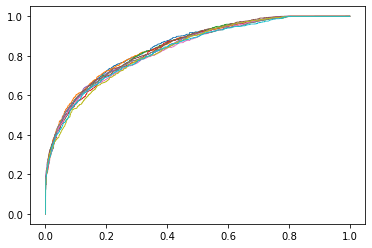

In [8]:
total_accuracy = []
total_f1 = []
total_pre = []
total_recall = []
total_auc = []
for i in range(10):
    pred = result[i]['pred']
    test = result[i]['test']
    fpr, tpr, _ = roc_curve(test, pred)
    roc_auc = auc(fpr, tpr)
    total_auc.append(roc_auc)
    plt.plot(fpr, tpr, lw=0.8)
    t_acc = []
    t_f1 = []
    t_pre = []
    t_rec = []
    for t in np.arange(0,1,0.05):
        p_val = np.zeros(pred.shape)
        p_val[pred > t] = 1
        t_acc.append(accuracy_score(test, p_val))
        t_f1.append(f1_score(test, p_val))
        t_pre.append(precision_score(test, p_val))
        t_rec.append(recall_score(test, p_val)) 
    total_accuracy.append(np.max(t_acc))
    total_f1.append(np.max(t_f1))
    total_pre.append(np.max(t_pre))
    total_recall.append(np.max(t_rec)) 
    
plt.savefig('resortDNN.png')

In [9]:
total_res = {'auc':total_auc, 'acc': total_accuracy, 'f1': total_f1,
            'pre': total_pre, 'recall': total_recall}

In [10]:
# total
for k, v in total_res.items():
    print(k, '\t', min(v), max(v), np.average(v))

auc 	 0.8314275205890614 0.8482341286611347 0.8400622901920952
acc 	 0.8017973040439341 0.81827259111333 0.8119071392910634
f1 	 0.621656050955414 0.6437692646411273 0.634082343484826
pre 	 0.9767441860465116 1.0 0.9965116279069768
recall 	 1.0 1.0 1.0


In [11]:
total_res

{'auc': [0.8482341286611347,
  0.8472852389594676,
  0.8435476082975893,
  0.8390184904391903,
  0.8430130451104298,
  0.8455405498850392,
  0.8322584972259528,
  0.838546869455244,
  0.8314275205890614,
  0.8317509532978442],
 'acc': [0.8127808287568647,
  0.81827259111333,
  0.8132800798801797,
  0.8040439340988518,
  0.817773339990015,
  0.8115327009485771,
  0.8125312031952072,
  0.8180229655516725,
  0.8017973040439341,
  0.809036445332002],
 'f1': [0.643765903307888,
  0.6437692646411273,
  0.629613161405069,
  0.6355215465163109,
  0.6387068588903451,
  0.6426146010186757,
  0.6282909415439535,
  0.6312118570183086,
  0.621656050955414,
  0.625673249551167],
 'pre': [1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  0.9767441860465116,
  1.0,
  0.9883720930232558],
 'recall': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]}

In [12]:
np.average(total_res['auc'])

0.8400622901920952

In [13]:
np.average(total_res['acc'])

0.8119071392910634